After embedding of low resolution 32x32 images into a 2D space using umap, a difference in the distributions of train and test appears.
There is a cluster of many similar images in the test set, that are not so frequent in the train data.

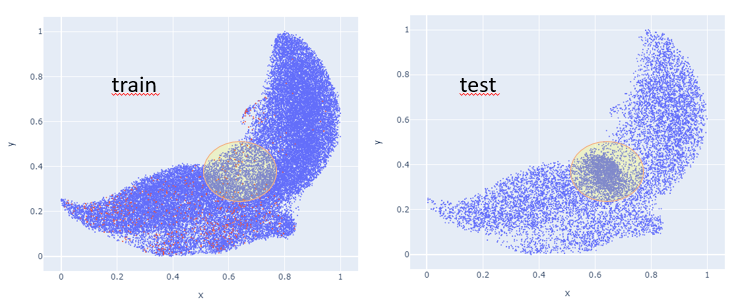


In [ ]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/


In [ ]:
import cudf, cuml
import cupy as cp
import numpy as np
import pandas as pd
import os
import random, re, math, time

random.seed(a=42)
from os.path import join 

import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image

from cuml.manifold import TSNE, UMAP

from tqdm import tqdm
import plotly.express as px

In [ ]:
BASEPATH = '../input'
COMPPATH = os.path.join(BASEPATH, 'siim-isic-melanoma-classification')
df_train = pd.read_csv(os.path.join(COMPPATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(COMPPATH, 'test.csv'))
df_sub = pd.read_csv(os.path.join(COMPPATH, 'sample_submission.csv'))

THUMBSPATH = os.path.join(BASEPATH, 'melanoma-extract-thumbs-32x32')
thumbs_train = np.load(os.path.join(THUMBSPATH, 'thumbs_32x32_train.npy'))
thumbs_test = np.load(os.path.join(THUMBSPATH, 'thumbs_32x32_test.npy'))

SIZE = thumbs_train.shape[1]


In [ ]:
thumbs_all = np.concatenate([thumbs_train, thumbs_test])
(n,y,x,b) = thumbs_all.shape
flat_all = thumbs_all.reshape((n, y*x*b))

umapObj = UMAP(n_components=2, n_neighbors=100, min_dist=0.7)
emb_all = umapObj.fit_transform(flat_all)

emb_train = emb_all[:thumbs_train.shape[0]]
emb_test = emb_all[thumbs_train.shape[0]:]

## All train and test images

Right-click image and open it in new browser tab. Its a 3000x3000 pixel image ;-)

In [ ]:
def draw_embedding(embedding, thumbs):
    (n, w) = embedding.shape
    if w > 32:
        embedding = PCA(n_components=32).fit_transform(embedding)

    if w > 2:
        #embedding = TSNE(n_components=2, verbose=2,metric="cosine").fit_transform(embedding)    
        embedding = TSNE(n_components=2, verbose=2).fit_transform(embedding)    

    x1, x2 = min(embedding[:,0]), max(embedding[:,0])
    y1, y2 = min(embedding[:,1]), max(embedding[:,1])
    
    #s = np.std(embedding, axis=0)
    #m = np.mean(embedding, axis=0)       
    #embedding = (embedding-m) / s / 3
    
    embedding[:,0] = (embedding[:,0] - x1) / (x2-x1)
    embedding[:,1] = (embedding[:,1] - y1) / (y2-y1)

    (n, w) = embedding.shape
    img = Image.new(mode='RGB', size=(3000, 3000))
    for i in range(n):
        img2 = Image.fromarray(thumbs[i])
        x = math.floor(embedding[i,0]*(3000-SIZE))
        y = 3000 - math.floor(embedding[i,1]*(3000-SIZE)) - SIZE
        img.paste(img2, (x, y))

    display(img)

In [ ]:
draw_embedding(emb_all, thumbs_all)

## Train:

In [ ]:
y_train = df_train["target"].values
y_train_str = np.array([str(i) for i in y_train])
fig = px.scatter(x=emb_train[:,0], y=emb_train[:,1], color=y_train_str, size=y_train, render_mode="webgl")
fig.update_traces(marker=dict(size=2))

fig.show()

## Test:

In [ ]:
fig = px.scatter(x=emb_test[:,0], y=emb_test[:,1], render_mode="webgl")
fig.update_traces(marker=dict(size=2))

fig.show()


In [ ]:
np.save('umap_emb_train.npy', emb_train)
np.save('umap_emb_test.npy', emb_test)